<a href="https://colab.research.google.com/github/medhareddy1906/798R_phase2/blob/main/Copy_of_Untitled10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install PyWavelets
!pip install imblearn
!pip install mne




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 37.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.3361 - loss: 0.7119 - val_accuracy: 0.5333 - val_loss: 0.6933
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5472 - loss: 0.6894 - val_accuracy: 0.4667 - val_loss: 0.6987
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4706 - loss: 0.6962 - val_accuracy: 0.4667 - val_loss: 0.7013
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5722 - loss: 0.6764 - val_accuracy: 0.4667 - val_loss: 0.6916
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5055 - loss: 0.6855 - val_accuracy: 0.6000 - val_loss: 0.6862
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7347 - loss: 0.6518 - val_accuracy: 0.6000 - val_loss: 0.6837
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6759 - loss: 0.6424 - val_accuracy: 0.6667 - val_loss: 0.6745
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8223 - loss: 0.6016 - val_accuracy: 0.6000 - val_loss: 0.671

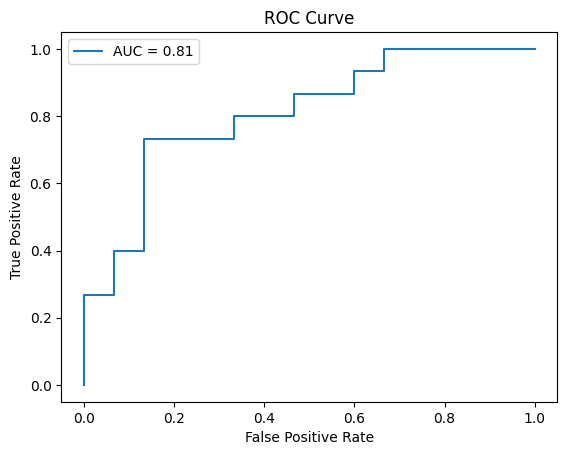

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pywt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

# Function to apply DWT for feature extraction
def apply_dwt(data, wavelet='db8', level=4):
    coeffs = [pywt.wavedec(channel, wavelet, level=level) for channel in data]
    return np.array([np.concatenate([c[-1], c[-2], c[-3], c[-4], c[-5]]) for c in coeffs])


data = np.random.rand(100, 19, 500)  # Example shape [samples, channels, time]
labels = np.random.randint(2, size=100)  # Example binary labels

# Apply DWT to each sample
processed_data = []
for i in range(data.shape[0]):
    processed_data.append(apply_dwt(data[i]))
processed_data = np.array(processed_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(processed_data, labels, test_size=0.3, random_state=42)

# Reshape for SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train.shape[1], X_train.shape[2])

# Model with CNN-BLSTM architecture
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
